In [1]:
import warnings
import numpy as np
from astropy import units as u
from astropy.coordinates import ICRS, AltAz, EarthLocation, SkyCoord
from astropy.table import QTable, unique
from astropy.time import Time
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.wcs import WCS
from astroquery.simbad import Simbad
from astroquery.exceptions import NoResultsWarning
from matplotlib import patheffects
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm

import plot_utils as pu

backgroundcolour = "#171726"
# backgroundcolour = "#000"
foregroundcolour = "#FFF"

cmap = LinearSegmentedColormap.from_list("sky", [backgroundcolour, foregroundcolour])

Simbad.reset_votable_fields()

generic_maximum_magnitude = 10

In [2]:
Simbad.list_votable_fields().show_in_notebook()

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

## User Inputs

In [3]:
location = "Toronto"
observation_point = (
    40 * u.deg,
    140 * u.deg,
)  # altitude (deg from horizon), azimuth (eastwards from north)
utc_conversion = -4 * u.hour
datetime = Time("2025-02-18 19:00:00") - utc_conversion

view_radius = 15 * u.deg
maximum_magnitude = 4

image_pixels = 250

## Convert Observing Point to RA/Dec

In [4]:
# query to a lat/long
earth_location = EarthLocation.of_address(location)

# generate a coordinate frame for the observation
earth_frame = AltAz(
    obstime=datetime,
    az=observation_point[1],
    alt=observation_point[0],
    location=earth_location,
)

# perform the conversion
ra_dec = earth_frame.transform_to(ICRS())

In [5]:
ra_dec = SkyCoord(ra='5h36m12.81s',dec='-1d12m6.91s')

## Query SIMBAD to get a catalogue of objects with relevant data

In [6]:
Simbad.reset_votable_fields()
Simbad.add_votable_fields("otype","flux","ids")
criteria = f"otype != 'err' AND flux < {generic_maximum_magnitude}"
query_result = QTable(
    Simbad.query_region(ra_dec, radius=view_radius, criteria=criteria)
)

# clean up the result
columns_to_remove = [
    "coo_err_min",
    "coo_err_angle",
    "coo_wavelength",
    "coo_bibcode",
    "coo_err_maj",
    "bibcode",
    "flux_err",
    "flux_err_prec",
    "flux_prec",
    "qual",
]
for colname in columns_to_remove:
    query_result.remove_column(colname)

# rename columns
query_result.rename_column("main_id", "id")
query_result.rename_column("otype", "object_type")
query_result.rename_column("filter", "magnitude.filter")
query_result.rename_column("flux", "magnitude")

# round columns
query_result["ra"] = query_result["ra"].round(5)
query_result["dec"] = query_result["dec"].round(5)
query_result["magnitude"] = query_result["magnitude"].round(3)

# create human-readable name column
query_result['ids_list'] = [i.split('|') for i in query_result['ids']]
names_column = []
for id, namelist in zip(query_result['id'].data, query_result['ids_list'].data):
    item_names = [n[5:] for n in namelist if "NAME" in n]
    if len(item_names) == 0:
        names_column.append(id)
    elif len(item_names) == 1:
        names_column.append(item_names[0])
    else:
        names_column.append('/'.join(item_names))
query_result["name"] = names_column
query_result.remove_columns(['ids', 'ids_list'])

## Filter data

In [7]:
# only keep items with magnitudes measured in visible
query_result = query_result[query_result["magnitude.filter"] == "V"]

# only keep items with magnitudes less than the given maximum
query_result = query_result[query_result["magnitude"] < maximum_magnitude]

# remove child elements
parents = query_result["id"][query_result["object_type"] == "**"].data
query_result.add_index("id")
for parent in parents:
    with warnings.catch_warnings(action='ignore', category=NoResultsWarning):
        children = QTable(Simbad.query_hierarchy(parent, hierarchy="children"))
    for child_id in children["main_id"].data:
        if child_id in query_result["id"]:
            query_result.remove_rows(query_result.loc_indices[child_id])

query_result = unique(query_result)

## Calculate image parameters

In [8]:
wcs = WCS(naxis=2)
wcs.wcs.crpix = [image_pixels / 2] * 2

degrees_per_pixel = (view_radius / (image_pixels / 2)).to(u.deg).value

wcs.wcs.cdelt = [degrees_per_pixel, degrees_per_pixel]
wcs.wcs.crval = [ra_dec.ra.value, ra_dec.dec.value]
wcs.wcs.ctype = ["RA", "DEC"]
wcs.wcs.cunit = [u.deg, u.deg]

query_result["flux"] = 10 ** (
    -query_result["magnitude"] / 2.5
)  # relative to V-band reference flux
query_result["flux"] = query_result["flux"].round(5)

# wavelength = 0.55 * u.micron # https://en.wikipedia.org/wiki/Apparent_magnitude#Standard_reference_values
# aperture_diameter = 3*u.mm # pupil size
# airy_disk_minimum = (1.22 * wavelength / aperture_diameter).decompose() * u.rad # radians from centre

airy_disk_minimum = 25 * u.arcmin / 2  # based on Vega spread in SIMBAD image
airy_disk_pixels = airy_disk_minimum.to(u.deg) / (degrees_per_pixel * u.deg)

# assume the airy disk is at 3x standard deviation of the Gaussian
std_dev = airy_disk_pixels / 3

# standard deviation is "diameter" whilst airy is "radius"
std_dev *= 2

query_result["scaled_flux"] = np.log10(query_result["flux"])
query_result["scaled_flux"] = query_result["scaled_flux"] - np.min(query_result["scaled_flux"]) + 0.2
query_result["scaled_flux"] /= np.max(query_result["scaled_flux"])
query_result["scaled_flux"] = query_result["scaled_flux"].round(5)

def get_intensity(radius, flux, sigma):
    """
    How much light is observed from a star at some radius away from it
    """
    exponential = np.exp(-(radius**2) / (sigma**2))

    return flux * exponential

In [9]:
query_result.sort('magnitude')
query_result

id,ra,dec,object_type,magnitude.filter,magnitude,name,flux,scaled_flux
,deg,deg,,,,,,
object,float64,float64,object,object,float32,str81,float64,float64
* bet Ori,78.63447,-8.20164,s*b,V,0.13,Rigel,0.88716,1.0
* alf Ori,88.79294,7.40706,s*r,V,0.42,Betelgeuse,0.6792,0.93302
* gam Ori,81.28276,6.3497,V*,V,1.64,Bellatrix,0.2208,0.65127
* eps Ori,84.05339,-1.20192,s*b,V,1.69,Alnilam,0.21086,0.63972
* zet Ori,85.18969,-1.94257,**,V,1.77,Alnitak,0.19588,0.62125
* kap Ori,86.93912,-9.6696,s*b,V,2.06,Saiph,0.14997,0.55428
* del Ori,83.00167,-0.2991,**,V,2.41,Mintaka,0.10864,0.47344
NGC 1980,83.81,-5.924,OpC,V,2.5,Lower Sword,0.1,0.45266


## Add stars to image

In [10]:
image = np.zeros((image_pixels, image_pixels))

maxradius = np.ceil(10 * std_dev)  # calculate contribution out to 5 standard deviations
radius_vector = np.arange(-maxradius, maxradius + 1).astype(int)
area = np.array(
    np.meshgrid(radius_vector, radius_vector)
)  # mesh of points which will map to around the star

radial_distance = np.sqrt(
    area[0] ** 2 + area[1] ** 2
)  # radius measurement at each of the meshgrid points

unique_radii = np.unique(radial_distance)

# all of the locations where each unique radius is found
radius_locations = [
    np.array(np.where(radial_distance == radius)).T for radius in unique_radii
]


for name, ra, dec, flux in query_result[["name", "ra", "dec", "scaled_flux"]]:
    skycoord = SkyCoord(ra=ra, dec=dec)  # star location
    x, y = np.round(skycoord.to_pixel(wcs)).astype(int)

    # do all points at some given radius at once
    for radius, points in zip(unique_radii, radius_locations):
        brightness = get_intensity(radius, flux, std_dev)

        for area_x, area_y in points:
            # get the pixel locations where this radius applies
            x_ = x + area[1][area_x, area_y]
            y_ = y + area[0][area_x, area_y]

            if (0 <= x_ < image.shape[1]) and (0 <= y_ < image.shape[0]):
                image[y_, x_] += brightness

## Plot result

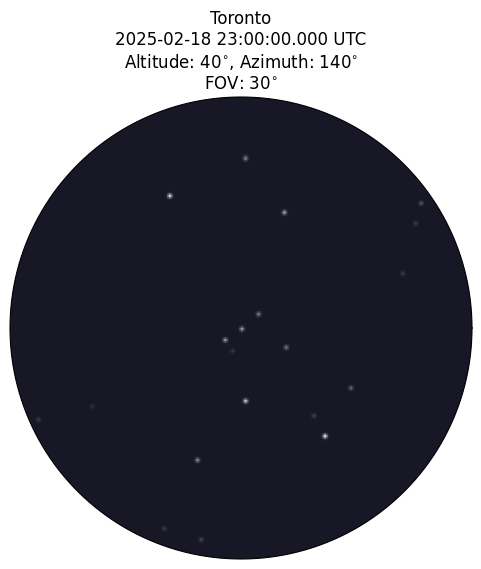

In [11]:
fig, ax = pu.fig_setup(wcs=wcs, plot_kwargs={"frame_class": EllipticalFrame})

im = ax.imshow(image, vmin=0, vmax=1, cmap=cmap)

pu.style_wcs_axes(ax, axis_ticks=(False, False))
ax.invert_xaxis()

location_string = f"{location}"
datetime_string = f"{datetime} UTC"
altaz_string = f"Altitude: {observation_point[0].to_string(format="latex")}, Azimuth: {observation_point[1].to_string(format="latex")}"
fov_string = f'FOV: {(2*view_radius).to_string(format="latex")}'
ax.set_title(f"{location_string}\n{datetime_string}\n{altaz_string}\n{fov_string}")

plt.show()

# pu.save_fig(fig, "SkySim")